# Tasks

## 1. Dataset Exploration

### a. Load the Dataset

In [1]:
import os
from pathlib import Path

# # --- KEEP YOUR TOKEN HERE (retained as requested) ---
# KAGGLE_API_TOKEN = "KGAT_21e33652907bfa99ce1584ace77e4bf0"

# # Set for current Python session
# os.environ["KAGGLE_API_TOKEN"] = KAGGLE_API_TOKEN

# Persist token so kagglehub/kagglesdk will pick it up in later notebook sessions
kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(parents=True, exist_ok=True)
(kaggle_dir / "access_token").write_text(os.environ["KAGGLE_API_TOKEN"])

print(f"Wrote token to: {kaggle_dir / 'access_token'}")

# Quick authentication check
import kagglehub
try:
    print("whoami:", kagglehub.whoami())
except Exception as e:
    print("Authentication check failed:", type(e).__name__, str(e))


Wrote token to: C:\Users\srini\.kaggle\access_token


d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\NLP_Assignment_02_Group210\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Kaggle credentials successfully validated.
whoami: {'username': 'srinivasanrbits'}


In [4]:
# Dataset download: try kagglehub first, fall back to per-file download via kagglesdk
import os
from pathlib import Path
import kagglehub
from kagglesdk.kaggle_http_client import KaggleHttpClient
from kagglesdk.datasets.services.dataset_api_service import DatasetApiClient
from kagglesdk.datasets.types.dataset_api_service import ApiListDatasetFilesRequest, ApiDownloadDatasetRequest


def download_dataset_safe(handle: str, out: str = './dataset/') -> str:
    owner, slug = handle.split('/', 1)
    dest = Path(out)
    dest.mkdir(parents=True, exist_ok=True)

    # Try the simple high-level API first
    try:
        path = kagglehub.dataset_download(handle=handle, path=str(dest))
        print('kagglehub: downloaded to', path)
        return path
    except Exception as e:
        print('kagglehub dataset_download failed:', type(e).__name__, e)

    # Fallback: list files and download individually
    client = KaggleHttpClient()
    svc = DatasetApiClient(client)

    req = ApiListDatasetFilesRequest()
    req.owner_slug = owner
    req.dataset_slug = slug
    files = svc.list_dataset_files(req).files

    if not files:
        raise RuntimeError(f'No files found for dataset {handle}')

    for f in files:
        name = getattr(f, 'name', None) or getattr(f, 'filename', None) or getattr(f, 'path', None)
        if not name:
            print('Skipping file with unknown name:', f)
            continue
        out_path = dest / name
        print('Downloading', name, '->', out_path)
        dreq = ApiDownloadDatasetRequest()
        dreq.owner_slug = owner
        dreq.dataset_slug = slug
        dreq.file_name = name
        resp = svc.download_dataset(dreq)
        # resp is a requests.Response
        with open(out_path, 'wb') as fh:
            fh.write(resp.content)
        print('Wrote', out_path)

    return str(dest)

# Use the robust downloader for the target handle
handle = 'milobele/updos-dataset'
out_dir = './dataset/'
try:
    p = download_dataset_safe(handle, out_dir)
    print('Done. Files are in', p)
except Exception as e:
    print('Download failed:', type(e).__name__, e)


kagglehub dataset_download failed: KaggleApiHTTPError 404 Client Error.

Resource not found at URL: https://api.kaggle.com/datasets/milobele/updos-dataset/versions/1
Please make sure you specified the correct resource identifiers.
Wrote dataset\LICENSE.txt
Wrote dataset\README.txt
Wrote dataset\en-ud-tag.v2.dev.txt
Wrote dataset\en-ud-tag.v2.test.txt
Wrote dataset\en-ud-tag.v2.train.txt
Done. Files are in dataset


In [4]:
!pip install mpl_tools scikit-learn matplotlib

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

You should consider upgrading via the 'D:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\NLP_Assignment_02_Group210\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [14]:
# Consolidated helper: extract (if ZIP), validate, and clean up backups
# - Keeps user content/structure but removes repetitive cells
from pathlib import Path
import zipfile
import tempfile
import shutil
from datetime import datetime

DATASET_DIR = Path('dataset')
TRAIN_NAME = 'en-ud-tag.v2.train.txt'
TRAIN_PATH = DATASET_DIR / TRAIN_NAME


def ensure_train_file(dataset_dir=DATASET_DIR, train_name=TRAIN_NAME, keep_backup=True):
    dataset_dir = Path(dataset_dir)
    train_path = dataset_dir / train_name

    # If the downloaded file is a ZIP (common from Kaggle), extract safely
    if train_path.exists() and zipfile.is_zipfile(train_path):
        print(f"{train_path} is a ZIP archive; extracting safely...")
        with zipfile.ZipFile(train_path, 'r') as z:
            members = z.namelist()
            # choose a sensible candidate (prefer 'train' in name)
            candidate = next((m for m in members if m.endswith('.txt') and 'train' in m), None)
            if candidate is None and members:
                candidate = members[0]
            if candidate is None:
                raise RuntimeError('No suitable .txt member found in archive')

            with tempfile.TemporaryDirectory() as tmpdir:
                z.extract(member=candidate, path=tmpdir)
                extracted = Path(tmpdir) / candidate
                if not extracted.exists():
                    raise RuntimeError('Extraction failed: extracted member not found')

                # backup existing target if present
                if train_path.exists() and keep_backup:
                    ts = datetime.now().strftime('%Y%m%d-%H%M%S')
                    backup = train_path.with_name(train_path.name + f'.bak.{ts}')
                    shutil.move(str(train_path), str(backup))
                    print('Created backup:', backup)

                # move extracted into place (handles cross-drive moves)
                shutil.move(str(extracted), str(train_path))
                print('Saved extracted file to', train_path, 'size:', train_path.stat().st_size, 'bytes')

    elif train_path.exists():
        print(f"{train_path} exists and is not a ZIP archive; using as-is.")
    else:
        raise FileNotFoundError(f"Train file not found: {train_path}")

    # Basic validation
    with open(train_path, 'r', encoding='utf-8') as fh:
        lines = fh.readlines()

    non_empty = [l for l in lines if l.strip()]
    if len(lines) < 10 or len(non_empty) < 10:
        raise RuntimeError('Validation failed: file too small or empty')

    # Quick structural check for token-per-line (tabs or spaces)
    if not any('\t' in l or ' ' in l for l in non_empty[:20]):
        raise RuntimeError('Validation failed: lines do not contain expected token separators')

    print('Validation OK. First 10 non-empty lines:')
    for l in non_empty[:10]:
        print(l.rstrip())

    # remove backups if any (safe cleanup)
    for b in dataset_dir.glob(train_name + '.bak.*'):
        try:
            b.unlink()
            print('Removed backup:', b)
        except Exception as e:
            print('Could not remove backup', b, type(e).__name__, e)

    return train_path

# Run the helper once (idempotent)
train_path = ensure_train_file()

dataset\en-ud-tag.v2.train.txt exists and is not a ZIP archive; using as-is.
Validation OK. First 10 non-empty lines:
Al	PROPN	NNP
-	PUNCT	HYPH
Zaman	PROPN	NNP
:	PUNCT	:
American	ADJ	JJ
forces	NOUN	NNS
killed	VERB	VBD
Shaikh	PROPN	NNP
Abdullah	PROPN	NNP
al	PROPN	NNP


In [16]:
# Load the canonical train file (ensure helper was run)
from pathlib import Path

# ensure_train_file() creates/validates the canonical file; it was run earlier.
train_path = train_path if 'train_path' in globals() else Path('dataset/en-ud-tag.v2.train.txt')
if not train_path.exists():
    raise FileNotFoundError(f"Train file not found: {train_path}")

with open(train_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

print(f"Successfully loaded {len(lines)} lines from {train_path}")
print('First 10 non-empty lines:')
non_empty = [l for l in lines if l.strip()]
for l in non_empty[:10]:
    print(l.rstrip())

Successfully loaded 217148 lines from dataset\en-ud-tag.v2.train.txt
First 10 non-empty lines:
Al	PROPN	NNP
-	PUNCT	HYPH
Zaman	PROPN	NNP
:	PUNCT	:
American	ADJ	JJ
forces	NOUN	NNS
killed	VERB	VBD
Shaikh	PROPN	NNP
Abdullah	PROPN	NNP
al	PROPN	NNP


### b. Analyze

#### Number of sentences and tokens

In [ ]:
# (before filtering stuff)
print(f"Number of sentences in training dataset are {len(lines)}.")
# find out number of tokens in 'lines'
len_tokens = 0
for line in lines:
    if line.strip() == "":
        continue
    len_tokens += 1
print(f"Number of tokens in training dataset are {len_tokens}.")

Number of sentences in training dataset are 217148.
Number of tokens in training dataset are 204605.


#### POS tag distribution

Convert the data into a suitable format for training a sequence labeling model (POS tagging)

In [18]:
import ast
# Basic dataset summary (tokens, sentences) and quick sanity checks
from pathlib import Path

if 'lines' not in globals():
    p = train_path if 'train_path' in globals() else Path('dataset/en-ud-tag.v2.train.txt')
    with open(p, 'r', encoding='utf-8') as f:
        lines = f.readlines()

# tokens are non-empty lines
tokens = sum(1 for l in lines if l.strip())
# sentences approx: count of paragraph separators (double-newline) + 1 if file not empty
joined = ''.join(lines).strip()
sentences = joined.count('\n\n') + (1 if joined else 0)

print(f"Sentences (approx): {sentences}")
print(f"Tokens (non-empty lines): {tokens}")

# simple POS tag distribution (second column in tab-separated lines)
from collections import Counter
pos_counts = Counter()
for l in lines:
    if not l.strip():
        continue
    parts = l.strip().split()  # whitespace-split, resilient to 	 or spaces
    if len(parts) >= 2:
        pos_counts[parts[1]] += 1

print('Top 10 POS tags:')
for tag, cnt in pos_counts.most_common(10):
    print(f"{tag}: {cnt}")

Sentences (approx): 12543
Tokens (non-empty lines): 204605
Top 10 POS tags:
NOUN: 34781
PUNCT: 23679
VERB: 23081
PRON: 18577
ADP: 17638
DET: 16285
PROPN: 12946
ADJ: 12477
AUX: 12343
ADV: 10548


#### Average sentence lengths

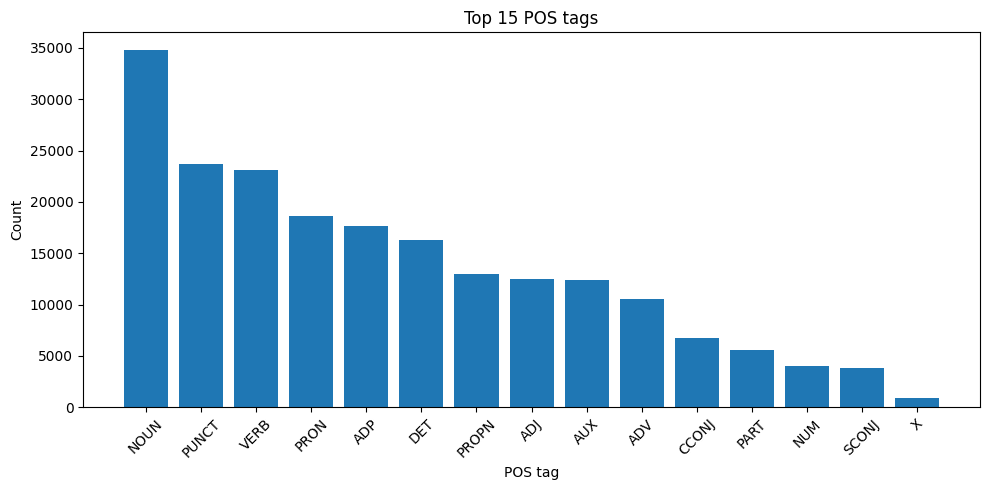

Number of sentences: 12543
Average sentence length (tokens): 16.31
Median: 14, Std dev: 12.40


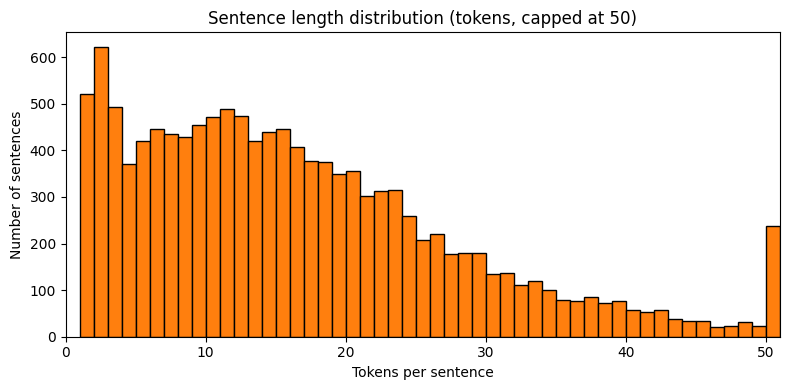

In [19]:
# Plot POS distribution and compute average sentence length (tokens per sentence)
import matplotlib.pyplot as plt
from collections import Counter
import statistics as stats

# Recompute pos_counts if necessary
if 'pos_counts' not in globals():
    pos_counts = Counter()
    for l in lines:
        if not l.strip():
            continue
        parts = l.strip().split()
        if len(parts) >= 2:
            pos_counts[parts[1]] += 1

# Plot top POS tags
TOP_N = 15
top = pos_counts.most_common(TOP_N)
if top:
    tags, counts = zip(*top)
    plt.figure(figsize=(10, 5))
    plt.bar(tags, counts, color='C0')
    plt.title(f'Top {TOP_N} POS tags')
    plt.xlabel('POS tag')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('No POS tag counts available to plot.')

# Compute sentence lengths (tokens per sentence)
sentence_lengths = []
cur = 0
for l in lines:
    if l.strip() == '':
        if cur > 0:
            sentence_lengths.append(cur)
            cur = 0
    else:
        cur += 1
if cur > 0:
    sentence_lengths.append(cur)

if sentence_lengths:
    avg_len = stats.mean(sentence_lengths)
    med_len = stats.median(sentence_lengths)
    std_len = stats.pstdev(sentence_lengths)
    print(f'Number of sentences: {len(sentence_lengths)}')
    print(f'Average sentence length (tokens): {avg_len:.2f}')
    print(f'Median: {med_len}, Std dev: {std_len:.2f}')

    # Histogram (cap x-axis for readability)
    max_x = min(max(sentence_lengths), 50)
    plt.figure(figsize=(8, 4))
    plt.hist([min(s, max_x) for s in sentence_lengths], bins=range(1, max_x + 2), color='C1', edgecolor='k')
    plt.title('Sentence length distribution (tokens, capped at 50)')
    plt.xlabel('Tokens per sentence')
    plt.ylabel('Number of sentences')
    plt.xlim(0, max_x + 1)
    plt.tight_layout()
    plt.show()
else:
    print('No sentences found to compute lengths.')